In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, binom

# Параметры
N = 1000  # количество пар выборок
m = 50    # размер выборки 
alpha = 0.05  # заданный уровень значимости
nu = 4

np.set_printoptions(precision=6, suppress=True)

### Генерация выборок (нормальное и равномерное распределения)

In [19]:
def generate_samples(m, nu):
    # Нормальное распределение: матожидание = nu, дисперсии произвольные
    mean = nu
    sigma1 = np.random.uniform(1, 5)
    sigma2 = np.random.uniform(1, 5)
    sample1_norm = np.random.normal(mean, sigma1, m)
    sample2_norm = np.random.normal(mean, sigma2, m)
    
    # Равномерное распределение: среднее = nu, ширина произвольная
    width1 = np.random.uniform(2, 10)
    width2 = np.random.uniform(2, 10)
    a1 = mean - width1/2
    b1 = mean + width1/2
    a2 = mean - width2/2
    b2 = mean + width2/2
    sample1_unif = np.random.uniform(a1, b1, m)
    sample2_unif = np.random.uniform(a2, b2, m)
    
    return (sample1_norm, sample2_norm), (sample1_unif, sample2_unif)

### Критерий Уэлча (t-критерий с разными дисперсиями)

In [20]:
def welch_test(sample1, sample2, alpha=0.05):
    t_stat, p_value = ttest_ind(sample1, sample2, equal_var=False)
    reject = p_value < alpha
    return p_value, reject

### Оценка действительного уровня значимости для нормального и равномерного распределений

In [21]:
def estimate_alpha(N, m, nu, alpha=0.05):
    rejections_norm = 0
    rejections_unif = 0
    
    for _ in range(N):
        (s1_n, s2_n), (s1_u, s2_u) = generate_samples(m, nu)
        _, reject_n = welch_test(s1_n, s2_n, alpha)
        _, reject_u = welch_test(s1_u, s2_u, alpha)
        if reject_n:
            rejections_norm += 1
        if reject_u:
            rejections_unif += 1
    
    alpha_hat_norm = rejections_norm / N
    alpha_hat_unif = rejections_unif / N
    
    # Доверительный интервал для доли (биномиальный)
    ci_norm = binom.interval(0.95, N, alpha_hat_norm)
    ci_unif = binom.interval(0.95, N, alpha_hat_unif)
    
    ci_norm = (ci_norm[0]/N, ci_norm[1]/N)
    ci_unif = (ci_unif[0]/N, ci_unif[1]/N)
    
    return alpha_hat_norm, ci_norm, alpha_hat_unif, ci_unif

alpha_hat_norm, ci_norm, alpha_hat_unif, ci_unif = estimate_alpha(N, m, nu, alpha)
print(f"Нормальное распределение: оценка α = {alpha_hat_norm:.4f}, доверительный интервал: {ci_norm}")
print(f"Равномерное распределение: оценка α = {alpha_hat_unif:.4f}, доверительный интервал: {ci_unif}")

Нормальное распределение: оценка α = 0.0460, доверительный интервал: (np.float64(0.033), np.float64(0.059))
Равномерное распределение: оценка α = 0.0480, доверительный интервал: (np.float64(0.035), np.float64(0.062))


### Проверка значимости различий с заданным α

In [22]:
def check_significance(alpha_hat, ci, alpha=0.05):
    lower, upper = ci
    if lower <= alpha <= upper:
        return "Нет значимых различий (α попадает в доверительный интервал)"
    else:
        return "Есть значимые различия (α не попадает в доверительный интервал)"

print("Нормальное распределение:", check_significance(alpha_hat_norm, ci_norm, alpha))
print("Равномерное распределение:", check_significance(alpha_hat_unif, ci_unif, alpha))

Нормальное распределение: Нет значимых различий (α попадает в доверительный интервал)
Равномерное распределение: Нет значимых различий (α попадает в доверительный интервал)


### График зависимости доверительного интервала от размера выборки m

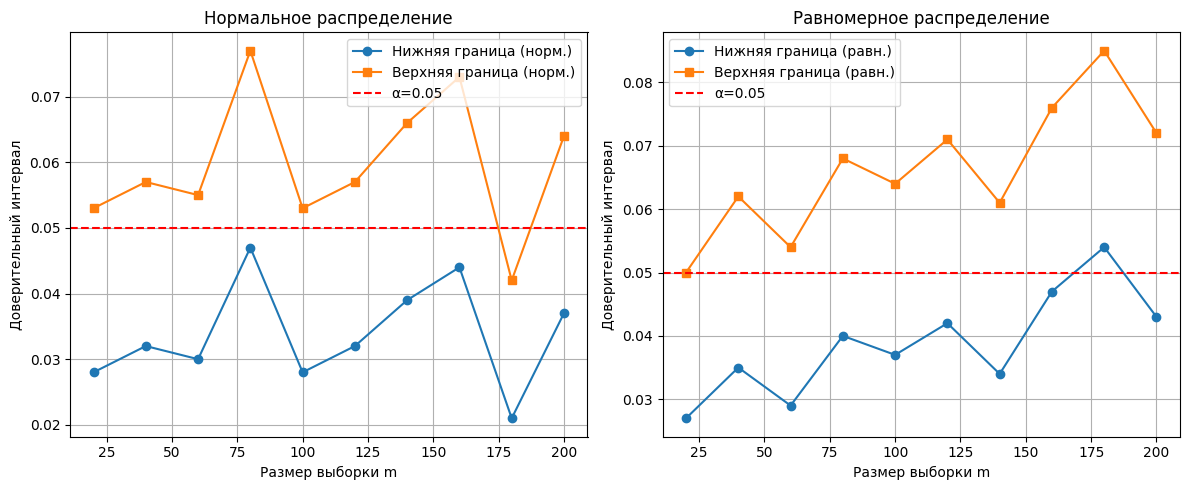

In [23]:
def plot_ci_vs_m(nu, alpha=0.05):
    m_values = range(20, 201, 20)
    ci_lower_norm = []
    ci_upper_norm = []
    ci_lower_unif = []
    ci_upper_unif = []
    
    for m in m_values:
        _, ci_n, _, ci_u = estimate_alpha(N, m, nu, alpha)
        ci_lower_norm.append(ci_n[0])
        ci_upper_norm.append(ci_n[1])
        ci_lower_unif.append(ci_u[0])
        ci_upper_unif.append(ci_u[1])
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(m_values, ci_lower_norm, label='Нижняя граница (норм.)', marker='o')
    plt.plot(m_values, ci_upper_norm, label='Верхняя граница (норм.)', marker='s')
    plt.axhline(y=alpha, color='r', linestyle='--', label=f'α={alpha}')
    plt.xlabel('Размер выборки m')
    plt.ylabel('Доверительный интервал')
    plt.title('Нормальное распределение')
    plt.legend()
    plt.grid()
    
    plt.subplot(1, 2, 2)
    plt.plot(m_values, ci_lower_unif, label='Нижняя граница (равн.)', marker='o')
    plt.plot(m_values, ci_upper_unif, label='Верхняя граница (равн.)', marker='s')
    plt.axhline(y=alpha, color='r', linestyle='--', label=f'α={alpha}')
    plt.xlabel('Размер выборки m')
    plt.ylabel('Доверительный интервал')
    plt.title('Равномерное распределение')
    plt.legend()
    plt.grid()
    
    plt.tight_layout()
    plt.show()

plot_ci_vs_m(nu, alpha)

### Учет наследственной погрешности (γ = 1%)

In [24]:
gamma = 0.01  # 1% относительной погрешности

def add_error(sample, gamma):
    # Добавляем относительную погрешность
    error = np.random.uniform(-gamma, gamma, size=sample.shape)
    return sample * (1 + error)

def monte_carlo_hereditary_error(N, m, nu, gamma, alpha=0.05):
    undecided_count = 0
    
    for _ in range(N):
        (s1_n, s2_n), (s1_u, s2_u) = generate_samples(m, nu)
        
        # Добавляем погрешность
        s1_n_err = add_error(s1_n, gamma)
        s2_n_err = add_error(s2_n, gamma)
        s1_u_err = add_error(s1_u, gamma)
        s2_u_err = add_error(s2_u, gamma)
        
        # Критерий Уэлча с погрешностью
        _, reject_n = welch_test(s1_n_err, s2_n_err, alpha)
        _, reject_u = welch_test(s1_u_err, s2_u_err, alpha)
        
        # Если невозможно принять решение (p-value близко к alpha)
        p_n, _ = welch_test(s1_n, s2_n, alpha)
        p_u, _ = welch_test(s1_u, s2_u, alpha)
        
        if abs(p_n - alpha) < 0.01 or abs(p_u - alpha) < 0.01:
            undecided_count += 1
    
    return undecided_count / N

undecided_fraction = monte_carlo_hereditary_error(N, m, nu, gamma, alpha)
print(f"Доля выборок, для которых нельзя принять решение из-за погрешности: {undecided_fraction:.4f}")

Доля выборок, для которых нельзя принять решение из-за погрешности: 0.0400


### График зависимости доли неопределенных случаев от размера выборки m

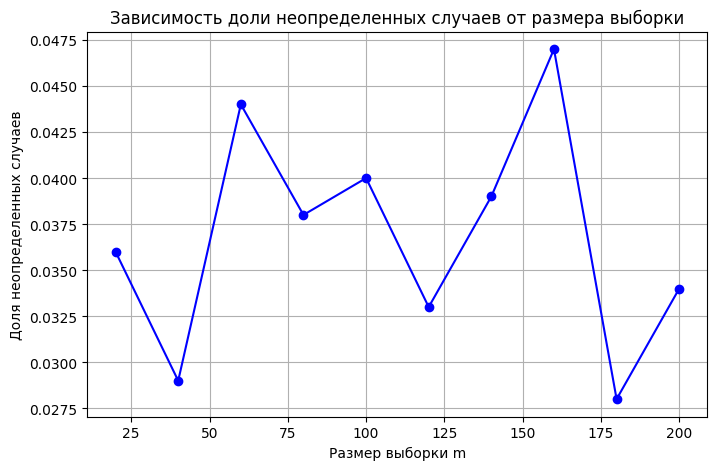

In [25]:
def plot_undecided_vs_m(nu, gamma, alpha=0.05):
    m_values = range(20, 201, 20)
    fractions = []
    
    for m in m_values:
        frac = monte_carlo_hereditary_error(N, m, nu, gamma, alpha)
        fractions.append(frac)
    
    plt.figure(figsize=(8, 5))
    plt.plot(m_values, fractions, marker='o', linestyle='-', color='b')
    plt.xlabel('Размер выборки m')
    plt.ylabel('Доля неопределенных случаев')
    plt.title('Зависимость доли неопределенных случаев от размера выборки')
    plt.grid()
    plt.show()

plot_undecided_vs_m(nu, gamma, alpha)